# 1. Loading and Inspecting Data

In [1]:
#Importing packages
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load dataset
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test  = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
#Feature to predict
target = list(set(train.columns) - set(test.columns))
target = target[0] 

## X/Y datasets

In [4]:
X_train = train.loc[:, train.columns != target]
Y_train = train[target]

X_test = test

#Drop id
X_test_id = X_test["Id"]

X_train.drop(columns='Id',inplace=True)
X_test.drop(columns='Id',inplace=True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

## Fill NaN values

In [5]:
def fillNa_df(df):
    
    #select object columns
    obj_col = df.columns[df.dtypes == 'object'].values

    #select non object columns
    num_col = df.columns[df.dtypes != 'object'].values

    #replace null value in obj columns with None
    df[obj_col] = df[obj_col].fillna('None')

    #replace null value in numeric columns with 0
    df[num_col] = df[num_col].fillna(0)
    
    return df

X_train_001 = fillNa_df(X_train)
X_test_001 = fillNa_df(X_test)

## Encoding ordinal/categorical features

In [6]:
from sklearn.preprocessing import OneHotEncoder

def oneHotEncoding(df_train, df_test):
    
    #select object columns
    obj_col = df_train.columns[df_train.dtypes == 'object'].values

    # creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown='ignore')

    # Ordinal features
    ordinal_features = [x for x in obj_col]

    # passing cat column (label encoded values)
    df_train_encoded = pd.DataFrame(enc.fit_transform(df_train[ordinal_features]).toarray())
    df_test_encoded  = pd.DataFrame(enc.transform(df_test[ordinal_features]).toarray())
    
    df_train_encoded.reset_index(drop=True, inplace=True)
    df_test_encoded.reset_index(drop=True, inplace=True)

    # merge with main df
    df_train_encoded = pd.concat([df_train, df_train_encoded], axis=1)
    df_test_encoded  = pd.concat([df_test,  df_test_encoded], axis=1)

    # drop ordinal features
    df_train_encoded.drop(columns=ordinal_features, inplace=True)
    df_test_encoded.drop(columns=ordinal_features, inplace=True)
    
    return df_train_encoded, df_test_encoded

X_train_002, X_test_002 = oneHotEncoding(X_train_001, X_test_001)

# Feature Engineering

In [7]:
def featureEng(df):

    #TotalBath
    df['TotalBath'] = (df['FullBath'] + df['HalfBath'] + df['BsmtFullBath'] + df['BsmtHalfBath'])

    #TotalPorch
    df['TotalPorch'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])

    #Modeling happen during the sale year
    df["RecentRemodel"] = (df["YearRemodAdd"] == df["YrSold"]) * 1

    #House sold in the year it was built
    df["NewHouse"] = (df["YearBuilt"] == df["YrSold"]) * 1

    #YrBltAndRemod
    df["YrBltAndRemod"] = df["YearBuilt"] + df["YearRemodAdd"]

    #Total_sqr_footage
    df["Total_sqr_footage"] = df["BsmtFinSF1"] + df["BsmtFinSF2"] + df["1stFlrSF"] + df["2ndFlrSF"]

    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    df['Area_Qual'] = df['TotalSF'] * df['OverallQual']

    #HasPool
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

    #HasFireplaces
    df['HasFirePlace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    #Has2ndFloor
    df['Has2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

    #HasGarage
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

    #HasBsmnt
    df['HasBsmnt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    
    return df

#Feature Engineering
X_train_003 = featureEng(X_train_002)
X_test_003 = featureEng(X_test_002)

# Outlier Detection

Perhaps the most important hyperparameter in the model is the “contamination” argument, which is used to help estimate the number of outliers in the dataset. This is a value between 0.0 and 0.5 and by default is set to 0.1.

In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


def dropoutlier(df_X, df_Y, method='IsolationForest'):

    if(method=='IsolationForest'):
        #Isolation Forest

        # identify outliers in the training dataset
        iso = IsolationForest(contamination=0.012)
        yhat = iso.fit_predict(df_X)

    if(method=='MinimumCovarianceDeterminant'):
        #Minimum Covariance Determinant

        # identify outliers in the training dataset
        ee = EllipticEnvelope(contamination=0.01, n_jobs=-1, random_state=42)
        yhat = ee.fit_predict(df_X)

    if(method=='LocalOutlierFactor'):
        #Local Outlier Factor

        # identify outliers in the training dataset
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(df_X)

    if(method=='OneClassSVM'):
        #One-Class SVM

        # identify outliers in the training dataset
        ee = OneClassSVM(nu=0.001)
        yhat = ee.fit_predict(df_X)

    # select all rows that are not outliers
    mask = yhat != -1
    df_X_drop, df_Y_drop = df_X[mask], df_Y[mask]

    # select all rows that are outliers
    masko = yhat == -1
    df_X_o, df_Y_o = df_X[masko], df_Y[masko]
    
    return df_X, df_Y, [df_X_o, df_Y_o]

#Drop outliers
X_train_004, Y_train_004, df_o = dropoutlier(X_train_003, Y_train)

# summarize the shape of the updated training dataset
print('Total: ', X_train_004.shape)
print('Not Outliers: ', X_train_003.shape)
print('Outliers: ', df_o[0].shape)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Total:  (1460, 316)
Not Outliers:  (1460, 316)
Outliers:  (18, 316)


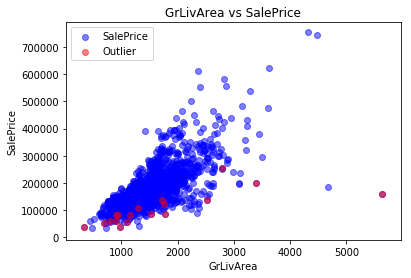

In [9]:
#Plot GrLivArea vs SalePrice
plt.scatter(X_train_004['GrLivArea'], Y_train_004, color='blue', alpha=0.5)
plt.scatter(df_o[0]['GrLivArea'],   df_o[1],   color='red',  alpha=0.5, label='Outlier')
plt.legend(loc="upper left")
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

# Split dataframe - Train Validation

In [10]:
#Importing packages
from sklearn.model_selection import train_test_split

#Particiona o data set originalmente Train em Train(Treino) e Val(validação)
X_train_005, X_val_005, Y_train_005, Y_val_005 = train_test_split(X_train_004, 
                                                                  Y_train_004, 
                                                                  test_size=0.2, 
                                                                  random_state=42)

X_train_005.shape, X_val_005.shape

((1168, 316), (292, 316))

# 5. Fit Models

## 5.2 XGBoost

In [11]:
#Importing Packages
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import Imputer

**GridSearchCV params:**
* **estimator:** estimator object
* **param_grid :** dict or list of dictionaries
* **scoring:** A single string or a callable to evaluate the predictions on the test set. If None, the estimator’s score method is used.
    * https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
* **n_jobs:** Number of jobs to run in parallel. None means. -1 means using all processors.
* **cv:** cross-validation, None, to use the default 3-fold cross validation. Integer, to specify the number of folds in a (Stratified)KFold.

In [12]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor(tree_method='gpu_hist')

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [13]:
#Run only in the first run of the kernel.
#hyperParameterTuning(X_train_005, Y_train_005)

### Best Params
<br>{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

### Best Fit

In [14]:
#Model fit
xgb_model = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.7,
        learning_rate = 0.1,
        max_depth = 3,
        min_child_weight = 1,
        n_estimators = 500,
        subsample = 0.7)

eval_set = [(X_val_005, Y_val_005)]

xgb_model.fit(X_train_005, Y_train_005, early_stopping_rounds=10, eval_metric="mae", eval_set = eval_set, verbose=False)

print('MAE: ', xgb_model.evals_result()['validation_0']['mae'][-1])

MAE:  16043.125


In [15]:
Y_val_pred = xgb_model.predict(X_val_005)

# 7. Plot Results

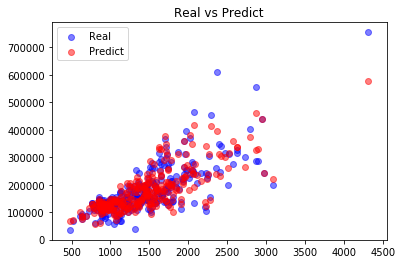

In [16]:
#Plot Real vs Predict
plt.scatter(X_val_005['GrLivArea'], Y_val_005,   color='blue', label='Real',    alpha=0.5)
plt.scatter(X_val_005['GrLivArea'], Y_val_pred,  color='red' , label='Predict', alpha=0.5)
plt.title("Real vs Predict")
plt.legend(loc='best')
plt.show()

# 8. Predic Test & Submission

In [17]:
# Use the model to make predictions
Y_pred_test = xgb_model.predict(X_test_003)

submission = pd.DataFrame({'Id':X_test_id,'SalePrice':Y_pred_test})

# Save results
submission.to_csv("submission.csv",index=False)